#### Imports

In [1]:
# builtins
from time import time
# general
import numpy as np
import pandas as pd
import scipy
# statistical tests
from scipy.stats import ttest_ind, ranksums, ks_2samp
# spatial transcriptomics packages
import anndata as ad
import scanpy as sc

#### Custom Functions

In [2]:
# converts seconds to '__ hrs, __ min, __.__ sec'
def betterTime(s):
    hrs = 0
    mins = 0
    while s >= 3600:
        s -= 3600
        hrs += 1
    while s >= 60:
        s -= 60
        mins += 1

    return str(hrs)+' hr, '+str(mins)+' min, '+str(round(s, 2))+' sec'


# takes in a list of 4 booleans corresponding to the suff_data value for each region
# returns list of region pairs to make statistical comparisons between
def comparisons(relevant):
    ls = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
    dellist = []
    for ind, pair in enumerate(ls):
        
        if relevant[pair[0]] == False or relevant[pair[1]] == False:
            dellist.append(ind)

    for ind in dellist[::-1]:
        ls.pop(ind)
    return ls

#### Loading data

In [3]:
cell_assignments = pd.read_csv('cell_assignments_filtered.csv')
region_assignments = pd.read_csv('concordex_cerebellum_res_2024-06-10.csv')
cereb_coords = np.load('cerebellum_coords_mat.npy')
cereb_counts = np.load('cerebellum_counts_mat.npy')
gene_labels = np.load('cerebellum_gene_labels.npy', allow_pickle=True)

cell_assignments = cell_assignments['first_type']
region_assignments = region_assignments['concordex_pred']

#### Full Preprocessing Code

In [4]:
# Setting up AnnData object
cereb_adata = ad.AnnData(cereb_counts)
cereb_adata.obs_names = ['Bead_'+str(i) for i in range(cereb_adata.n_obs)]
cereb_adata.var_names = gene_labels
cereb_adata.obs['cell_type'] = pd.Categorical(cell_assignments)
cereb_adata.obs['region'] = pd.Categorical(region_assignments)

# inverting y_coordinates because spatial plotting libraries were plotting the cerebellum
# upside down from usual display
x = cereb_coords[:, 0]
y = cereb_coords[:, 1]
new_y = y.max() - y
new_cereb_coords = np.array(list(zip(x, new_y)))
cereb_adata.obsm['spatial'] = new_cereb_coords


# Calculating % MT counts
mt_gene_ids = [i for i in range(14089, 14160)] + [i for i in range(23068, 23092)] # figured out these are the correct indices
mt_pcts = []
counts_matrix = cereb_adata.X
for bead_num in range(cereb_adata.n_obs):
    mt_pcts.append(np.sum(counts_matrix[bead_num][mt_gene_ids])/np.sum(counts_matrix[bead_num]))

cereb_adata.obs['pct_counts_mt'] = mt_pcts


# Filtering
print('Initial cells:', cereb_adata.n_obs)
print('Initial genes:', cereb_adata.n_vars)
sc.pp.filter_genes(cereb_adata, min_counts=50)
sc.pp.filter_genes(cereb_adata, min_cells=25)
cereb_adata = cereb_adata[cereb_adata.obs["pct_counts_mt"] < 0.1].copy()
print('Final cells:', cereb_adata.n_obs)
print('Final genes:', cereb_adata.n_vars)


# Finding total_counts (per gene) and n_cells_by_counts
cereb_adata.var.rename(columns={'n_counts':'total_counts', 'n_cells':'n_cells_by_counts'}, inplace=True)
    # filtering process somehow creates columns but we need to rename and reevaluate post-filtering

# Finding total_counts (gene) and n_cells_by_counts
cells_expressing  = []
expressions = []
X = cereb_adata.X.T 
    # transposes rows and columns so that genes are now rows
for gene_num in range(cereb_adata.n_vars):
    expressions.append(np.sum(X[gene_num]))
    cells_expressing.append(np.count_nonzero(X[gene_num]))

cereb_adata.var['n_cells_by_counts'] = cells_expressing
cereb_adata.var['total_counts'] = expressions


# Finding total_counts (cell) and n_genes_by_counts
genes_expressed  = []
total_counts = []
X = cereb_adata.X
for bead_num in range(cereb_adata.n_obs):
    total_counts.append(np.sum(X[bead_num]))
    genes_expressed.append(np.count_nonzero(X[bead_num]))

cereb_adata.obs['n_genes_by_counts'] = genes_expressed
cereb_adata.obs['total_counts'] = total_counts


# Normalization + log1p
sc.pp.normalize_total(cereb_adata)
sc.pp.log1p(cereb_adata)


# Finding post-normalization log1p_total_counts (cell and gene)
    # cell
total_counts = []
X = cereb_adata.X
for bead_num in range(cereb_adata.n_obs):
    total_counts.append(np.sum(X[bead_num]))

cereb_adata.obs['log1p_total_counts'] = total_counts

    # gene
total_counts = []
X = cereb_adata.X.T
for gene_num in range(cereb_adata.n_vars):
    total_counts.append(np.sum(X[gene_num]))

cereb_adata.var['log1p_total_counts'] = total_counts

Initial cells: 9985
Initial genes: 23096
Final cells: 9051
Final genes: 10293


#### Making df and comparisondf

In [ ]:
start = time()

dfDict = {}
comparisonDict = {}

cell_types = ['Astrocytes', 'Bergmann', 'Granule', 'MLI1', 'MLI2', 'Oligodendrocytes', 'Purkinje', 'Fibroblast', 'Golgi', 'Polydendrocytes']
gene_names = cereb_adata.var_names
print('Counting to', len(cereb_adata.var_names))

for counter, gene_name in enumerate(gene_names):
    if counter % 100 == 0:
        end = time()
        print(counter, ':', betterTime(end-start))

    gene = cereb_adata[:, gene_name]

    for cell_type in cell_types:
        handle = gene_name+'_'+cell_type
        relevant = []
        
        # df code
        for reg in range(4):
            cell_gene_reg = gene[(gene.obs['cell_type'] == cell_type) 
                                        & (gene.obs['region'] == reg)].X
            
            n_cells = len(cell_gene_reg)
            n_exprs = np.count_nonzero(cell_gene_reg)
            n_counts = float(cell_gene_reg.sum())

            pct_exprs = n_exprs/n_cells if n_cells != 0 else None

            suff_data = n_exprs > 10
            relevant.append(suff_data)

            dfDict[len(dfDict.keys())] = [gene_name, cell_type, handle, 
                                          reg, n_counts, n_exprs, n_cells, pct_exprs, suff_data]

        
        # comparisondf code
        for comp in comparisons(relevant):
            cell_gene_reg_a = gene[(gene.obs['cell_type'] == cell_type) 
                                        & (gene.obs['region'] == comp[0])].X.flatten()
            
            cell_gene_reg_b = gene[(gene.obs['cell_type'] == cell_type) 
                                        & (gene.obs['region'] == comp[1])].X.flatten()
            
            p_ttest = ttest_ind(cell_gene_reg_a, cell_gene_reg_b)[1] # p_value is stored in second element of function output
            p_wilcoxon = ranksums(cell_gene_reg_a, cell_gene_reg_b)[1]
            p_ks = ks_2samp(cell_gene_reg_a, cell_gene_reg_b)[1]

            # storing all p values into a comparison dictionary
            comparisonDict[len(comparisonDict.keys())] = [gene_name, cell_type, comp[0], comp[1], 
                                                          p_ttest, p_wilcoxon, p_ks]


# making dataframes from dictionaries
df_cols = ['gene_name', 'cell_type', 'plotname_handle', 'region', 
           'n_counts', 'n_exprs', 'n_cells', 'pct_exprs', 'suff_data']
df = pd.DataFrame.from_dict(data=dfDict, orient='index', columns=df_cols)

comparisondf_cols = ['gene_name', 'cell_type', 'region1', 'region2', 'ttest_p', 'wilcoxon_p', 'ks_p']
comparisondf = pd.DataFrame.from_dict(data=comparisonDict, orient='index', columns=comparisondf_cols)

# Bonferroni Correction
bonferroni_cutoff = 0.05/len(comparisondf)
passes_bonferroni = comparisondf[comparisondf['ttest_p'] < bonferroni_cutoff]

# save to file to load in later
df.to_csv('df.csv', index=False)
comparisondf.to_csv('comparisondf.csv', index=False)
passes_bonferroni.to_csv('passes_bonferroni.csv', index=False)

### Current work

In [12]:
# reading in already-created dataframes
df = pd.read_csv('fulldf_alltests.csv')
comparisondf = pd.read_csv('comparisondf.csv')
passes_bonferroni = pd.read_csv('passes_bonferroni.csv')
marker_genes = pd.read_csv('celltype_marker_genes.csv')[['cell_type', 'gene']]

In [14]:
#                blue/gran   green/PB  orange/oligo red/MLI     gray
master_palette = ['#1A476F', '#55752F', '#E69F00', '#C10534','#C1C1C1']

In [42]:
# individual gene, celltype: all data
genes = passes_bonferroni['gene_name'].unique()
cell_types = passes_bonferroni['cell_type'].unique()

gene_name = 'Lsamp'
cell_type = 'Astrocytes'

rows = passes_bonferroni[(passes_bonferroni['gene_name'] == gene_name) & 
                    (passes_bonferroni['cell_type'] == cell_type)]

if len(rows) != 0:
    regions = np.sort(pd.concat((rows['region1'], rows['region2'])).unique())
    handle = gene_name+'_'+cell_type
    
    # making df for plot
    cell_gene = cereb_adata[cereb_adata.obs['cell_type'] == cell_type][:, gene_name]
    
    ls1 = cell_gene.obs['region'] # regions
    ls2 = cell_gene.X.flatten()   # count data
    data = [[reg, ls2[ind]] for ind, reg in enumerate(ls1) if reg in regions] # only if it is of the regions we want
    index = list(range(len(ls1)))
    
    dfdict = dict(zip(index, data))
    col = ['region', 'log1p counts']
    newdf = pd.DataFrame.from_dict(data=dfdict, orient='index', columns=col)
    
    palette = [master_palette[i] for i in regions]
    
    box = iqplot.stripbox(
        data=newdf,
        q='log1p counts',
        cats='region',
        order=regions,
        frame_width=500,
        frame_height=300,
        spread='jitter',
        x_axis_label=gene_name+' counts in '+cell_type+' (log1p)',
        y_axis_label='region',
        palette=palette
    )

    box.xaxis.axis_label_text_font_size = '12pt'
    box.yaxis.axis_label_text_font_size = '12pt'
    box.xaxis.axis_label_text_font_style = 'normal'
    box.yaxis.axis_label_text_font_style = 'normal'
    
    ecdf = iqplot.ecdf(
        data=newdf,
        q='log1p counts',
        cats='region',
        order=regions,
        frame_width=500,
        frame_height=300,
        x_axis_label=gene_name+' counts in '+cell_type+' (log1p)',
        y_axis_label='cumulative probability',
        legend_location='bottom_right',
        palette=palette
    )

    ecdf.xaxis.axis_label_text_font_size = '12pt'
    ecdf.yaxis.axis_label_text_font_size = '12pt'
    ecdf.xaxis.axis_label_text_font_style = 'normal'
    ecdf.yaxis.axis_label_text_font_style = 'normal'
    
    multiplot = bokeh.layouts.gridplot([box, ecdf], ncols=1)

    # fname = './NewPassesBonferroni/'+handle+'_'+str(regions)+'.html'
    # bokeh.plotting.output_file(filename=fname)
    # bokeh.plotting.save(multiplot)

    bokeh.io.show(multiplot)

In [35]:
# individual gene: comparing regions

gene_name = 'Fth1'
regions = [0, 1, 2]

# making df for plot
gene = cereb_adata[:, gene_name]

ls1 = gene.obs['region'] # regions
ls2 = gene.X.flatten()   # count data
data = [[reg, ls2[ind]] for ind, reg in enumerate(ls1) if reg in regions] # only if it is of the regions we want
index = list(range(len(ls1)))

dfdict = dict(zip(index, data))
col = ['region', 'log1p counts']
newdf = pd.DataFrame.from_dict(data=dfdict, orient='index', columns=col)

# palette = [master_palette[i] for i in regions]

box = iqplot.stripbox(
    data=newdf,
    q='log1p counts',
    cats='region',
    order=regions,
    frame_width=500,
    frame_height=300,
    spread='jitter',
    y_axis_label='region',
    x_axis_label='Fth1 counts (log1p)',
    palette=master_palette
)

box.xaxis.axis_label_text_font_size = '12pt'
box.yaxis.axis_label_text_font_size = '12pt'
box.xaxis.axis_label_text_font_style = 'normal'
box.yaxis.axis_label_text_font_style = 'normal'
box.x_range = bokeh.models.Range1d(-.25, 4.25)

ecdf = iqplot.ecdf(
    data=newdf,
    q='log1p counts',
    cats='region',
    order=regions,
    frame_width=500,
    frame_height=300,
    y_axis_label='cumulative probability',
    x_axis_label='Fth1 counts (log1p)',
    legend_location='bottom_right',
    palette=master_palette
)

ecdf.xaxis.axis_label_text_font_size = '12pt'
ecdf.yaxis.axis_label_text_font_size = '12pt'
ecdf.xaxis.axis_label_text_font_style = 'normal'
ecdf.yaxis.axis_label_text_font_style = 'normal'
ecdf.x_range = bokeh.models.Range1d(-.25, 4.25)

multiplot = bokeh.layouts.gridplot([box, ecdf], ncols=1)

# fname = './fth1_all_regions.html'
# bokeh.plotting.output_file(filename=fname)
# bokeh.plotting.save(multiplot)

bokeh.io.show(multiplot)

#### Expression of "excitatory" genes vs proximity to granules

In [36]:
# average distance to nearest 10 granules

avg_dists_mli1 = []
for key in minidf_mli1.index:
    rowsort = minidf_mli1.loc[key].sort_values()
    avg_dists_mli1.append(rowsort[:10].mean())
    
avg_dists_mli1 = np.array(avg_dists_mli1)

In [37]:
far_bool = avg_dists_mli1 > np.median(avg_dists_mli1
close_bool = ~far_bool # not(far_bool)

far_inds = mli1.index[far_bool]
close_inds = mli1.index[close_bool]

In [174]:
goi1 = 'Kcna1'
far_goi1 = np.array(cereb_adata[far_inds][:, goi1].X).flatten()
close_goi1 = np.array(cereb_adata[close_inds][:, goi1].X).flatten()

goi2 = 'Gnas'
far_goi2 = np.array(cereb_adata[far_inds][:, goi2].X).flatten()
close_goi2 = np.array(cereb_adata[close_inds][:, goi2].X).flatten()

'''
goi3 = 'Atp1b1'
far_goi3 = np.array(cereb_adata[far_inds][:, goi3].X).flatten()
close_goi3 = np.array(cereb_adata[close_inds][:, goi3].X).flatten()
'''


counts = np.concatenate((far_goi1, close_goi1, far_goi2, close_goi2))
dists = ['far' for i in range(len(far_goi1))] + ['close' for i in range(len(close_goi1))]
dists = dists*2
gene = [goi1 for i in range(len(mli1))] + [goi2 for i in range(len(mli1))] # + [goi3 for i in range(len(mli1))]

index = list(range(len(dists)))

col = ['gene', 'distance', 'counts']
dfdict = dict(zip(index, zip(gene, dists, counts)))

minidf = pd.DataFrame.from_dict(dfdict, columns=col, orient='index')

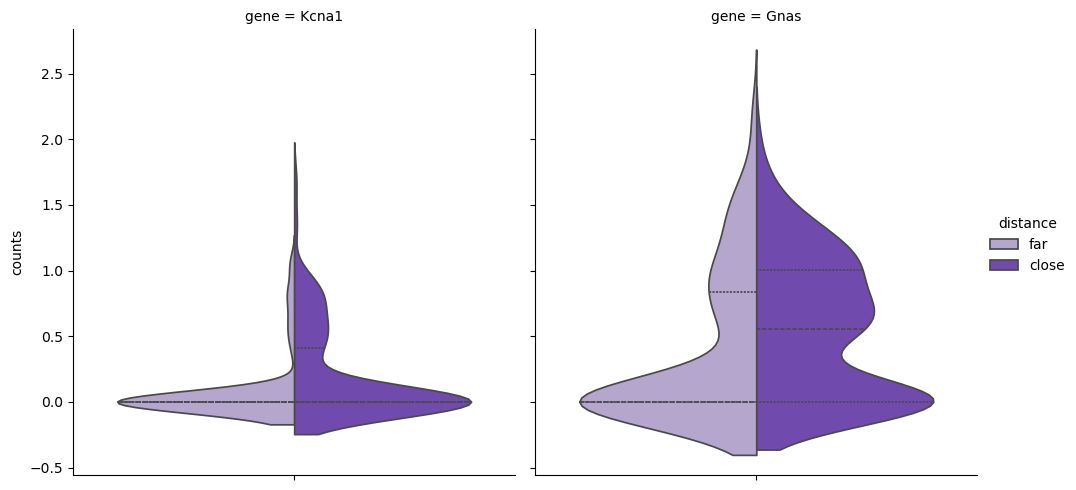

In [175]:
catplot_palette = ['#b49fd4', '#6d39bd']

sns.catplot(minidf, kind='violin', y='counts', 
            col='gene', hue='distance',
            split=True, inner='quart',
            palette=catplot_palette)

plt.savefig('./mli1_excitatory_egs1.png', dpi=150, bbox_inches='tight')
# plt.show()